<a href="https://colab.research.google.com/github/Miragekaefer/4-Gewinnt-erweitert/blob/main/Capstone_Project_TOD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project Geospace Maschine Learnig Model**

**Content:
Building a geospace Model to recognize different Usages of Land**

(description of our project / Reasons for choosing this project topic (City Planning through land usage recocnition)

In [ ]:
#### Requirements

#pip install datapackage
from datapackage import Package
import requests
import shutil
import os
import random

#installation of requirements.txt

# Replace this URL with the correct URL to your repository's raw requirements.txt
requirements_url = "https://raw.githubusercontent.com/PhilippWiessner/DataScience2/main/Model/requirements.txt"

# Fetch the content of requirements.txt
response = requests.get(requirements_url)
requirements_content = response.text

# Write the content to a local requirements.txt file
with open("requirements.txt", "w") as file:
    file.write(requirements_content)

# Install requirements
os.system("pip install -r requirements.txt")


256

**1. Data generation**

The initial phase in constructing a spatial-based model involves the collection of essential image data. To achieve this, we opted to use OpenStreetMaps, where images are pre-defined based on building types, road types, and more. This eliminates the need for manual scripting of every entity within each image, allowing us to concentrate on tasking of masking images for the learning process.

For obtaining these images locally, we utilized a Google download function, necessitating the use of the Google Cloud service and a dedicated API key.

"##"  This function takes coordinates and an optional zoom level, sends a request to the Google Maps API, and saves the obtained image locally.
The image file is stored with a filename based on its coordinates. The use of the Google Cloud service and API key ensures access to the required mapping data.
This initial phase sets the foundation for subsequent steps in building the geospace machine learning model.

In [ ]:
# function to donwload images from the googlestaticmap api
def download_images(coordinates, zoom=16):
    # define the request parameters
    url = "https://maps.googleapis.com/maps/api/staticmap?"
    api_key = ""
    size = "640x640"
    scale = "1"
    maptype = "satellite"

    # pose get request
    response = requests.get(url + "center=" + str(coordinates[0]) + "," + str(coordinates[1]) + "&zoom=" + str(zoom) + "&size=" + size + "&maptype=" + maptype + "&scale=" + scale + "&sensor=false" + "&key=" + api_key, stream=True,)
    #stream repsonse into file and save it
    with open(os.getcwd() + os.sep + "Data" + os.sep + "Images" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".png", "wb",) as out_file:
        shutil.copyfileobj(response.raw, out_file)
    #delete the repsonse arifact
    del response

Prior to utilizing the image downloader, we decided to predefine specific areas and coordinates. This precautionary step ensures that we exclude images from regions that are of no importance for the training model, such as images from oceans or seas.

Our approach involved taking a package that contains a list of all cities available in OpenStreetMaps, each with a population of 15,000 or more. This strategy was implemented to avoid irrelevant images and place a greater emphasis on the initial concept of city analysis.

In [ ]:
# Load dataset of all cities in the world with >15000 inhabitants
# package = Package("https://datahub.io/core/world-cities/datapackage.json")
##Problem: DataPackageException: Unable to load JSON at "https://datahub.io/core/world-cities/datapackage.json"
package = Package("https://raw.githubusercontent.com/datasets/world-cities/5eeadf346fe8ee2341597b4cb33531e85501c403/datapackage.json")

cities_list = package.get_resource("world-cities").read()

In [ ]:
# fetch random city contained in the dataset
def get_random_city():

    city = random.choice(cities_list)

    return city

The coordinates are required in establishing the length and width of each image, ensuring equality in size across all images. The following function is designed to define these coordinates based on the nodes of the OpenStreetMap image.

In [ ]:
def get_coordinates_from_id(osmid):

    # connect to overpass api endpoind
    api = overpy.Overpass()

    # query the api and save the response
    result = api.query(f"node({osmid});out;")

    for node in result.nodes:
        # extract coordinates from response
        coordinates = (float(node.lat), float(node.lon))

    # if coordinates are available return them
    try:
        return coordinates

    #else print error
    except:
        print(f"No coordinates for {osmid}")


To further suit our images for the training process, we check their compatibility by scaling them to a standardized size commonly used for map image data.

In [ ]:
def latLngToPoint(mapWidth, mapHeight, lat, lng):
    x = (lng + 180) * (mapWidth / 360)

    y = ((1 - math.log(math.tan(lat * math.pi / 180) + 1 / math.cos(lat * math.pi / 180)) / math.pi) / 2) * mapHeight

    return (x, y)



def pointToLatLng(mapWidth, mapHeight, x, y):
    lng = x / mapWidth * 360 - 180
    n = math.pi - 2 * math.pi * y / mapHeight
    lat = 180 / math.pi * math.atan(0.5 * (math.exp(n) - math.exp(-n)))


    return (lat, lng)



def getImageBounds(lat, lng, zoom):
    picHeight = 640
    picWidth = 640


    mapHeight = 256
    mapWidth = 256


    xScale = math.pow(2, zoom) / (picWidth / mapWidth)
    yScale = math.pow(2, zoom) / (picHeight / mapWidth)


    centreX, centreY = latLngToPoint(mapWidth, mapHeight, lat, lng)


    southWestX = centreX - (mapWidth / 2) / xScale
    southWestY = centreY + (mapHeight / 2) / yScale
    SWlat, SWlng = pointToLatLng(mapWidth, mapHeight, southWestX, southWestY)


    northEastX = centreX + (mapWidth / 2) / xScale
    northEastY = centreY - (mapHeight / 2) / yScale
    NElat, NElng = pointToLatLng(mapWidth, mapHeight, northEastX, northEastY)


    return [SWlat, SWlng, NElat, NElng]

With all nessessary functions established, the next step involves defining a list that includes all relevant land-use types. Since each node of the image data has an assigned type, we can employ a pre-defined set for land usages to ease this process.

In [ ]:
#list with all landuses
dictionary_landuse = [
    "commercial",
    "construction",
    "education",
    "fairground",
    "industrial",
    "residential",
    "retail",
    "institutional",
    "aquaculture",
    "allotments",
    "farmland",
    "farmyard",
    "paddy",
    "animal_keeping",
    "flowerbed",
    "forest",
    "greenhouse_horticulture",
    "meadow",
    "orchard",
    "plant_nursery",
    "vineyard",
    "basin",
    "salt_pond",
    "brownfield",
    "cemetery",
    "depot",
    "garages",
    "grass",
    "greenfield",
    "landfill",
    "military",
    "port",
    "quarry",
    "railway",
    "recreation_ground",
    "religious",
    "village_green",
    "winter_sports",
]

Our decision was to train the model on 5000 images.

The function concludes the data generation phase by generating a set of 5000 images for a specified number of cities. For each city, it randomly selects coordinates associated to various land uses, checks for data presence in the specified area, and downloads images for those coordinates. This marks the final step in preparing the dataset for subsequent model training.


In [ ]:
# function to generate a set of images for n cities
def get_random_samples(n=1):
    # loop to do multiple cities

    for x in range(n):

        # get a random city
        city = get_random_city()

        # get the coordinates for one of all the different landuses
        coordinates = get_coordinates_for_each_landuse(city)

        try:

            # loop over each coordinate
            for coordinate in coordinates:

                try:
                    # check if data is actually present in the given area
                    south, east, north, west = getImageBounds(
                        float(coordinate[0]), float(coordinate[1]), 16
                    )
                    landuse = ox.features_from_bbox(
                        north, south, east, west, tags={"landuse": True}
                    )
                    # download the image of the given coordinate
                    download_images(coordinate)

                except:
                    print("No landuse data was found")

        except:
            print("Coordinates were returned empty")

In [ ]:
# initial count of how much data is already in the folder
datanames = os.listdir(os.getcwd() + os.sep + "Data" + os.sep + "Images")

# loop as long as less then 5000 examples
while len(datanames) < 5000:

    get_random_samples()

    datanames = os.listdir(os.getcwd() + os.sep + "Data" + os.sep + "Images")

FileNotFoundError: [Errno 2] No such file or directory: '/content/Data/Images'

**2. Training the model**

**2.1 Combining satellite and OpenStreetMap data**

Now that we have obtained the necessary image data, we shifts to training the model for our specific objectives. As the model identifies various landuse types present in our images, our initial step involves assigning a color for each different landuse type to ease the evaluation. Due to certain steps in the model training process not accepting Hexcode colors, we additional assigned each land-use type a unique integer identifier.

In [ ]:
# map each landuse to a distinct color
landuse_mapped_hex = {
    "not_assigned": "#FFFFFF",
    "commercial": "#2F4F4F",
    "construction": "#556B2F",
    "education": "#A0522D",
    "fairground": "#006400",
    "industrial": "#8B0000",
    "residential": "#808000",
    "retail": "#483D8B",
    "institutional": "#778899",
    "aquaculture": "#BC8F8F",
    "allotments": "#008B8B",
    "farmland": "#00008B",
    "farmyard": "#32CD32",
    "paddy": "#DAA520",
    "animal_keeping": "#8FB88F",
    "flowerbed": "#8B008B",
    "forest": "#B03060",
    "greenhouse_horticulture": "#FF0000",
    "meadow": "#FF8C00",
    "orchard": "#FFFF00",
    "plant_nursery": "#0000CD",
    "vineyard": "#40E0D0",
    "basin": "#00FF00",
    "salt_pond": "#DC143C",
    "brownfield": "#00BFFF",
    "cemetery": "#A020F0",
    "depot": "#F08080",
    "garages": "#ADFF2F",
    "grass": "#DA70D6",
    "greenfield": "#FF7F50",
    "landfill": "#FF00FF",
    "military": "#F0E68C",
    "port": "#6495ED",
    "quarry": "#DDA0DD",
    "railway": "#B0E0E6",
    "recreation_ground": "#90EE90",
    "religious": "#FF1493",
    "village_green": "#7B68EE",
    "winter_sports": "#FFDAB9",
}

In [ ]:
# map each color to a integer value that later represents the individual ids
color_mapped_to_int = {
    "255255255": 0,
    "477979": 1,
    "8510747": 2,
    "1608245": 3,
    "01000": 4,
    "13900": 5,
    "1281280": 6,
    "7261139": 7,
    "119136153": 8,
    "188143143": 9,
    "0139139": 10,
    "00139": 11,
    "5020550": 12,
    "21816532": 13,
    "143188143": 14,
    "1390139": 15,
    "1764896": 16,
    "25500": 17,
    "2551400": 18,
    "2552550": 19,
    "00205": 20,
    "64224208": 21,
    "02550": 22,
    "2202060": 23,
    "0191255": 24,
    "16032240": 25,
    "240128128": 26,
    "17325547": 27,
    "218112214": 28,
    "25512780": 29,
    "2550255": 30,
    "240230140": 31,
    "100149237": 32,
    "221160221": 33,
    "176224230": 34,
    "144238144": 35,
    "25520147": 36,
    "123104238": 37,
    "255218185": 38,
}


Up to this point, our images are essentially snapshots of map data. To integrate our land-usages into the maps, we developed a function that determines the size of the images and reads the land-use type of each node. It can then apply the corresponding color to each node, therefore generating the initial plot for one of our map images.

In [ ]:
# Function to plot the openstreetmap data and save it as a .png
def plot_data(coordinates, zoom):
    # get the bounding box form the given coordinates and zoom level
    south, east, north, west = getImageBounds(
        float(coordinates[0]), float(coordinates[1]), zoom
    )

    # query openstreetmap for all landuse in the boundingbox
    landuse = ox.features_from_bbox(north, south, east, west, tags={"landuse": True})

    # create a plot
    fig, ax = plt.subplots(figsize=(8, 8), dpi=104)

    # for each landuse in the queried data, color the respective area in the earlier specified color
    for type in landuse["landuse"].unique():
        # filter so wrongly labeled data doesn't cause any issues (instances of this can be seen on the openstreetmap key wiki)
        if type in dictionary_landuse:
            # filter for the currently selected landuse and plot it.
            # turning of antialising and edgecolor is important as to not cause the creation of new colors on the edges of the areas that weren't assigned to a landuse
            landuse.loc[landuse["landuse"] == type].plot(
                ax=ax,
                color=landuse_mapped_hex[type],
                antialiased=False,
                edgecolor="none",
            )
    plt.xlim(east, west)
    plt.ylim(south, north)
    # turn of the axis, as to not save it in the image file
    plt.axis("off")
    # save the image file under the specified path
    fig.savefig(os.getcwd() + os.sep + "Data" + os.sep + "Masks" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".png", bbox_inches="tight", pad_inches=0,)
    # close the plot to reduce memory usage
    plt.close()
    # open the image again
    rgb_converted = Image.open(os.getcwd()+ os.sep+ "Data" + os.sep + "Masks" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".png")
    # convert it from rgba to rgb as we are not using the alpha values
    rgb_converted = rgb_converted.convert("RGB")
    # save it again
    rgb_converted.save(os.getcwd() + os.sep + "Data" + os.sep + "Masks" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".png")

The masks required for the eventual training of the model are based on these initial plots mentioned above. With similar aproaches involving defining bounds and color distribution, we create the mask to our initial map image plot.

In [ ]:
# function to create numpy masks form the .png masks
def generate_mask(coordinates):
    # create 640x640 array filled with zeros
    raster = np.zeros((640, 640))
    # load the specified image file
    image = Image.open(
        os.getcwd() + os.sep + "Data" + os.sep + "Masks" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".png")
    # convert the image to a numpy array for way faster processing times (2min vs 1sec for mask creation)
    image_array = np.array(image)
    # go through each pixel and map the pixelvalue to the corresponding unique id
    for line in range(640):
        for column in range(640):
            # get the value of the pixel in the image
            pixelvalue = image_array[line, column]
            # convert it to a string, because arrays can't be keys of dicitionaries, the easiest way to map the pixelvalues is by using their value as a string as keys
            pixelvalue = map(str, pixelvalue)
            colorvalue = "".join(pixelvalue)
            # map the pixelvalue to the correspoding id
            raster[line, column] = color_mapped_to_int[str(colorvalue)]
    # save the numpy array using savez_compress to reduce the used storage space (3000 kb vs 10kb)
    np.savez_compressed(os.getcwd() + os.sep + "Data" + os.sep + "Masks" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".npz", raster,)
    # delete the used picture
    os.remove(os.getcwd() + os.sep + "Data" + os.sep + "Masks" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".png")

This can then be looped through all the images available. In our case this porcess runs 5000 times.

In [ ]:
# function to loop over all satellite pictures and generate their masks
def create_all_masks():
    # get all filenames in Data/Images
    datanames = os.listdir(os.getcwd() + os.sep + "Data" + os.sep + "Images")
    # loop over all names
    for dataname in datanames:
        # extract coordinates out of filename
        coordinates = dataname.rstrip(".png").split("_")
        # check if numpy data already exists
        if not os.path.exists(os.getcwd() + os.sep + "Data" + os.sep + "Masks" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".npz"):
            coordinates = tuple(coordinates)
            try:
                # plot the data
                plot_data(coordinates, 16)
                # generate the numpy mask
                generate_mask(coordinates)
            except:
                # if errors occur delte the problematic satellite image
                print("An error occured while trying to generate the masks")
                os.remove( os.getcwd() + os.sep + "Data" + os.sep + "Images" + os.sep + str(coordinates[0]) + "_" + str(coordinates[1]) + ".png")

In [ ]:
create_all_masks()

In diesem Block wird eine Funktion create_all_masks definiert, die alle erforderlichen Schritte für die Erzeugung von Masken für Satellitenbilder durchführt. Hier sind die Hauptpunkte des Codes:

    Alle Dateinamen im Ordner "Data/Images" werden abgerufen.
    Eine Schleife durchläuft alle Dateinamen.
    Die Koordinaten werden aus dem Dateinamen extrahiert.
    Es wird überprüft, ob bereits Numpy-Daten vorhanden sind.
    Wenn keine Numpy-Daten vorhanden sind, wird versucht, die Funktionen plot_data (Erzeugung von Plotdaten) und generate_mask (Erzeugung von Masken) für die gegebenen Koordinaten aufzurufen.
    Bei auftretenden Fehlern wird das betreffende Satellitenbild gelöscht.
    Diese Schritte werden für alle verfügbaren Satellitenbilder durchgeführt, in diesem Fall 5000 Mal.

Insgesamt ermöglicht diese Funktion die automatisierte Generierung von Masken für alle verfügbaren Satellitenbilder, die im Modelltraining verwendet werden sollen.

**2.2. Creating the Dataloader**

The Dataloader process aligns to that from the lecture. Key points in our case are:


1.  **Mask Restucturing**: It is essential to reorganize the masks stored as numpy files to make them compatible with the datablock's y_coordinate.
2.   **Data Splitter**: We decided on using the RandomSplitter to split our images into train and test data.
3.   **GPU Setup**: Due to using pytorch and cuda we can manually setup the process to be ran on the GPU instead of the CPU



In [ ]:
# function to get the mask given an image
def get_mask(x):
    # load the numpyfile
    numpyfile = np.load(mask_path / f"{x.stem}.npz")
    # access the data stored in the compressed file format
    data = numpyfile.f.arr_0
    # close the file as to save memory
    numpyfile.close()
    # return the extracted mask
    return data

In [ ]:
# defining the datablock
satellite_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=dictionary_landuse)),
    get_items=get_image_files,
    get_y=get_mask,
    splitter=RandomSplitter(),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)

In [ ]:
# if pytorch and cuda is setup correctly enable the dataloader to run on the gpu by passing it the cuda device (Installation of cuda https://developer.nvidia.com/cuda-downloads is necessary)
if torch.cuda.is_available():
    dataloader = satellite_block.dataloaders(
        image_path, bs=32, device=torch.device("cuda")
    )


else:
    dataloader = satellite_block.dataloaders(image_path, bs=32)

2.3 Training the model

In diesem Abschnitt wurde ein U-Net-Modell mit ResNet34-Architektur trainiert, wobei drei verschiedene Lernraten in aufeinanderfolgenden Durchläufen verwendet wurden. Zuerst wurde eine dynamisch angepasste Lernrate mit frühzeitigem Stoppen eingesetzt. Im zweiten Durchlauf wurde das Modell unfreezed, und eine erneut angepasste Lernrate wurde verwendet. Im dritten Durchlauf wurde eine feste Lernrate angewendet. Die besten Modelle wurden während des Trainings gespeichert, und am Ende wurde das finale Modell exportiert.

learner text

In [ ]:
# define the unet learner, the metrics, also enable self attention, set mish as the activation function and pass ranger as the optimization function
learner = unet_learner(
    dataloader,
    resnet34,
    metrics=[dice_wo_bg, Dice],
    self_attention=True,
    act_cls=Mish,
    opt_func=ranger,
)

###

The code block utilizes the lr_find() method to identify the most effective learning rate for the learner. This is a crucial step for achieving efficient convergence during subsequent training.

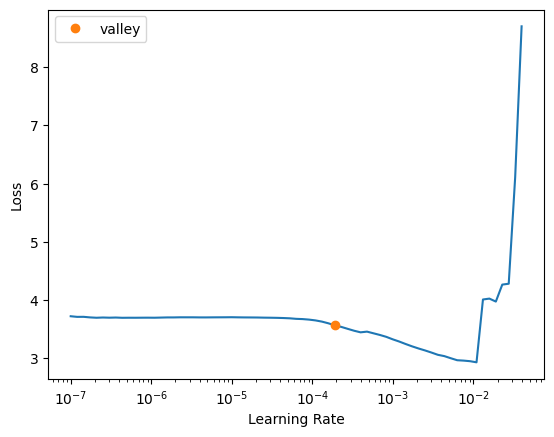

In [ ]:
#find learning rate
lr = learner.lr_find()

This block executes the first iteration of model training. The model is trained for a maximum of 20 epochs using the learning rate derived before. Early stopping, based on the custom metric "dice_wo_bg," is applied, and the model is saved as "first_pass" if an improvement in the metric is observed.

In [ ]:
# first pass model training, with early stopping after seeing no improvment in the custom defined metric for 4 epochs, train max of 20 epochs
learner.fit_one_cycle(
    20,
    lr_max=lr.valley,
    cbs=[
        EarlyStoppingCallback(
            monitor="dice_wo_bg", min_delta=0.01, patience=4, comp=np.greater
        ),
        SaveModelCallback(
            monitor="dice_wo_bg", min_delta=0.01, comp=np.greater, fname="first_pass"
        ),
    ],
)

epoch,train_loss,valid_loss,dice_wo_bg,dice,time


Better model found at epoch 0 with dice_wo_bg value: 0.27378812432289124.
Better model found at epoch 1 with dice_wo_bg value: 0.5348249077796936.
Better model found at epoch 2 with dice_wo_bg value: 0.6756325960159302.
No improvement since epoch 2: early stopping


This section block loads the machine learning model with weights saved after the initial training pass ("first_pass") and displays predictions for a subset of examples using the show_results method.

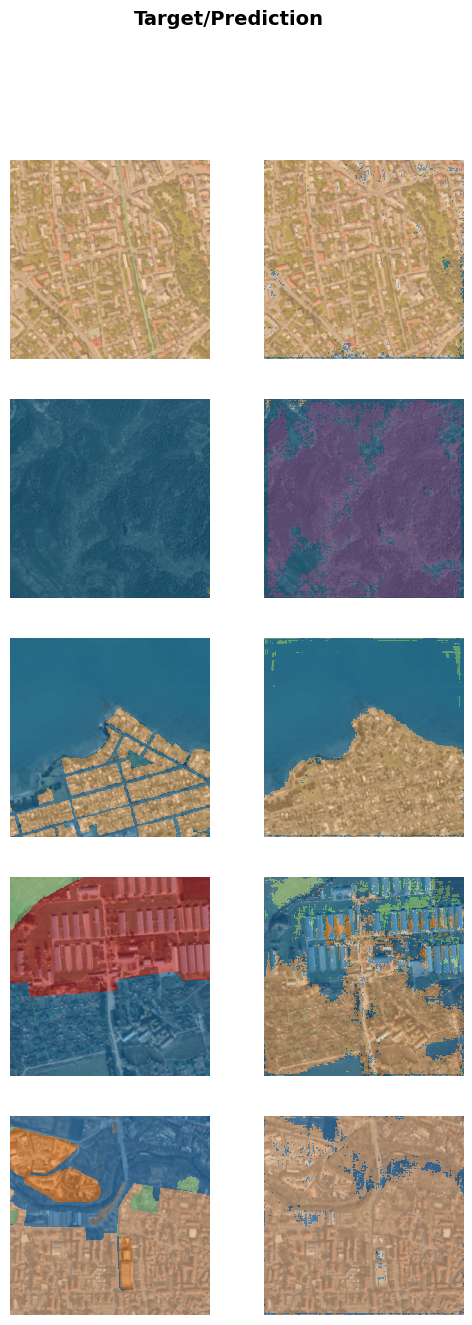

In [ ]:
# load the lerner and show some examples
learner = learner.load("first_pass")
learner.show_results(max_n=5)

This code block unfreezes the previously trained model to allow fine-tuning. Then, it determines a new optimal learning rate for further training using the lr_find() method.

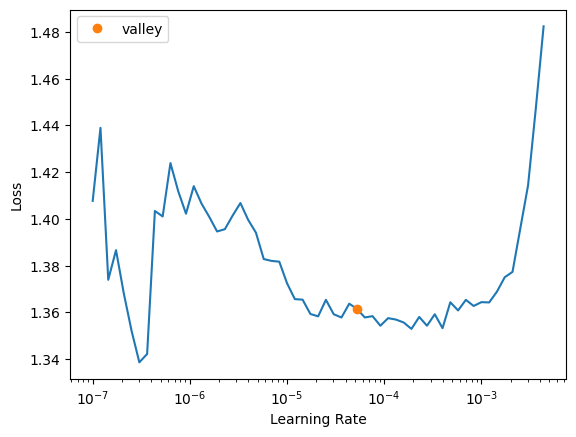

In [ ]:
# unfreeze the model and find a new learning rate
learner.unfreeze()
lr = learner.lr_find()

This block executes the second iteration of model training. It retrains the model again for 20 epochs, but adjusting the learning rate within a specified range based on the new optimal rate. Also early stopping is applied again in case of insufficient improvement.

In [ ]:
#train the model again for 20 epochs unless there is no improvment seen for 4 epochs
learner.fit_one_cycle(
    20,
    lr_max=slice(lr.valley / 10, lr.valley * 10),
    cbs=[
        EarlyStoppingCallback(
            monitor="dice_wo_bg", min_delta=0.01, patience=4, comp=np.greater
        ),
        SaveModelCallback(monitor="dice_wo_bg", comp=np.greater, fname="second_pass"),
    ],
)

epoch,train_loss,valid_loss,dice_wo_bg,dice,time


Better model found at epoch 0 with dice_wo_bg value: 0.6338990926742554.
Better model found at epoch 3 with dice_wo_bg value: 0.7134556770324707.
No improvement since epoch 3: early stopping


The code loads the machine learning model with weights saved from the second training pass ('second_pass') and generates predictions for a subset of examples using the show_results method.

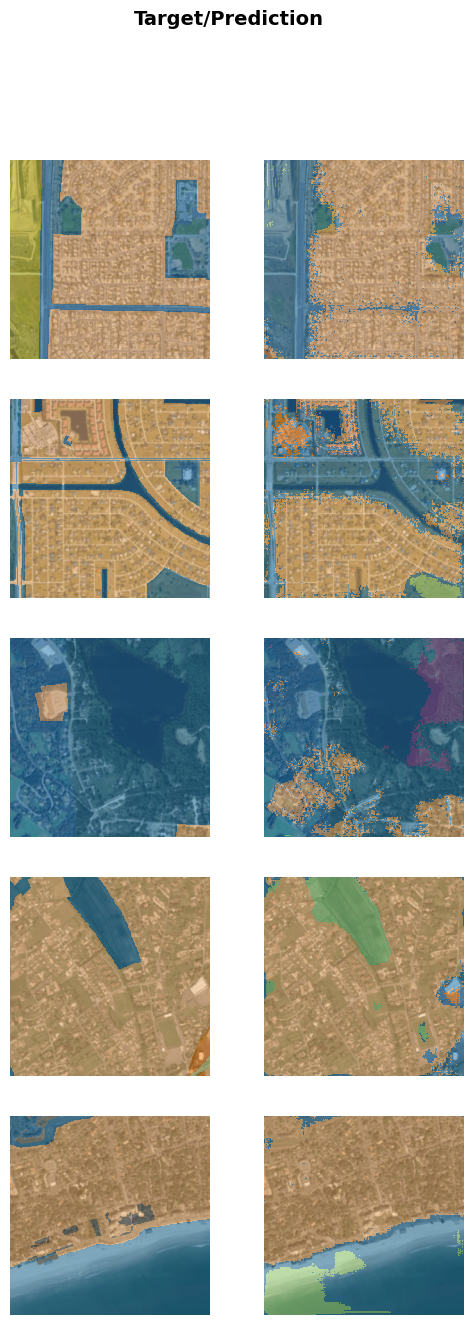

In [ ]:
# load the model and show some examples
learner = learner.load("second_pass")
learner.show_results(max_n=5)

Unfreezing the previously trained model to allow for fine-tuning. With that, a new optimal learning rate can be determined.

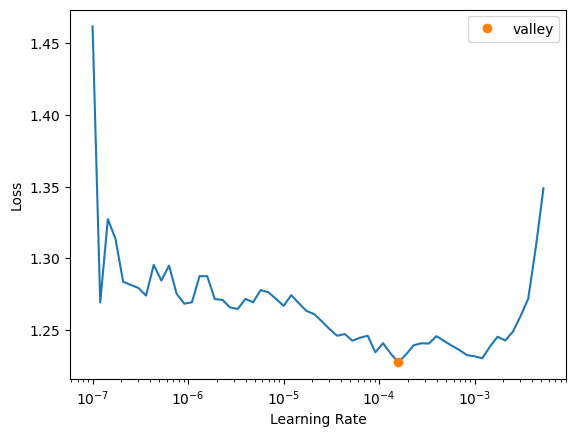

In [ ]:
# unfreeze the model and find a new learning rate
learner.unfreeze()
lr = learner.lr_find()

Retraining the model for a third time with the specified settings, utilizing the optimal learning rate range and implementing early stopping based on a custom metric.

In [ ]:
# train the model for a thrid time with the same settings
learner.fit_one_cycle(
    20,
    lr_max=slice(lr.valley / 10, lr.valley * 10),
    cbs=[
        EarlyStoppingCallback(
            monitor="dice_wo_bg", min_delta=0.01, patience=4, comp=np.greater
        ),
        SaveModelCallback(
            monitor="dice_wo_bg", comp=np.greater, fname="finetuned_model"
        ),
    ],
)

epoch,train_loss,valid_loss,dice_wo_bg,dice,time
0,1.147308,1.165475,0.635400,5.909199,19:05
1,1.186051,1.271192,0.648410,6.758679,18:19
2,1.205976,1.270805,0.636840,8.098472,18:33
3,1.250318,1.254542,0.701617,8.020090,18:34
4,1.261019,1.196111,0.628460,6.764313,16:11
5,1.204889,1.165898,0.702440,7.693769,13:32
6,1.170988,1.228492,0.652519,7.343034,13:32
7,1.141941,1.179482,0.644504,7.079226,13:33


Better model found at epoch 0 with dice_wo_bg value: 0.6354004740715027.
Better model found at epoch 1 with dice_wo_bg value: 0.6484102010726929.
Better model found at epoch 3 with dice_wo_bg value: 0.7016174793243408.
Better model found at epoch 5 with dice_wo_bg value: 0.702439546585083.
No improvement since epoch 3: early stopping


The code loads the model with weights saved after the third training pass ("finetuned_model") and displays predictions for a subset of examples.

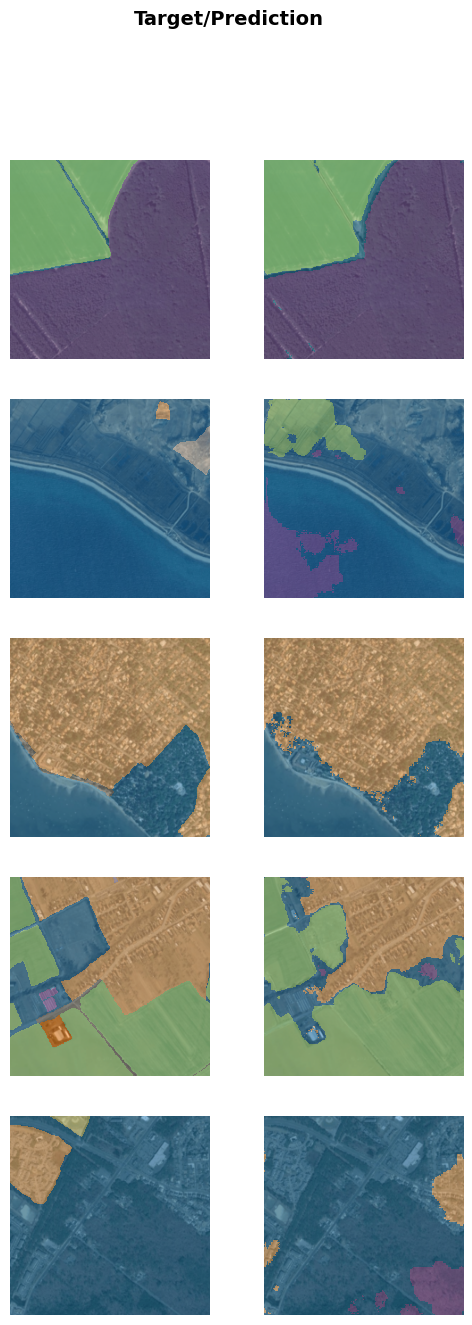

In [ ]:
# load the model and show some examples
learner = learner.load("finetuned_model")
learner.show_results(max_n=5)

[After the third training] Exporting the final machine learning model and saving it as a Pickle file named "model.pkl."


In [ ]:
# export the final model
learner = learner.load("finetuned_model")
learner.export(fname="model.pkl")